## Week 6 Homework

---

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*



In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

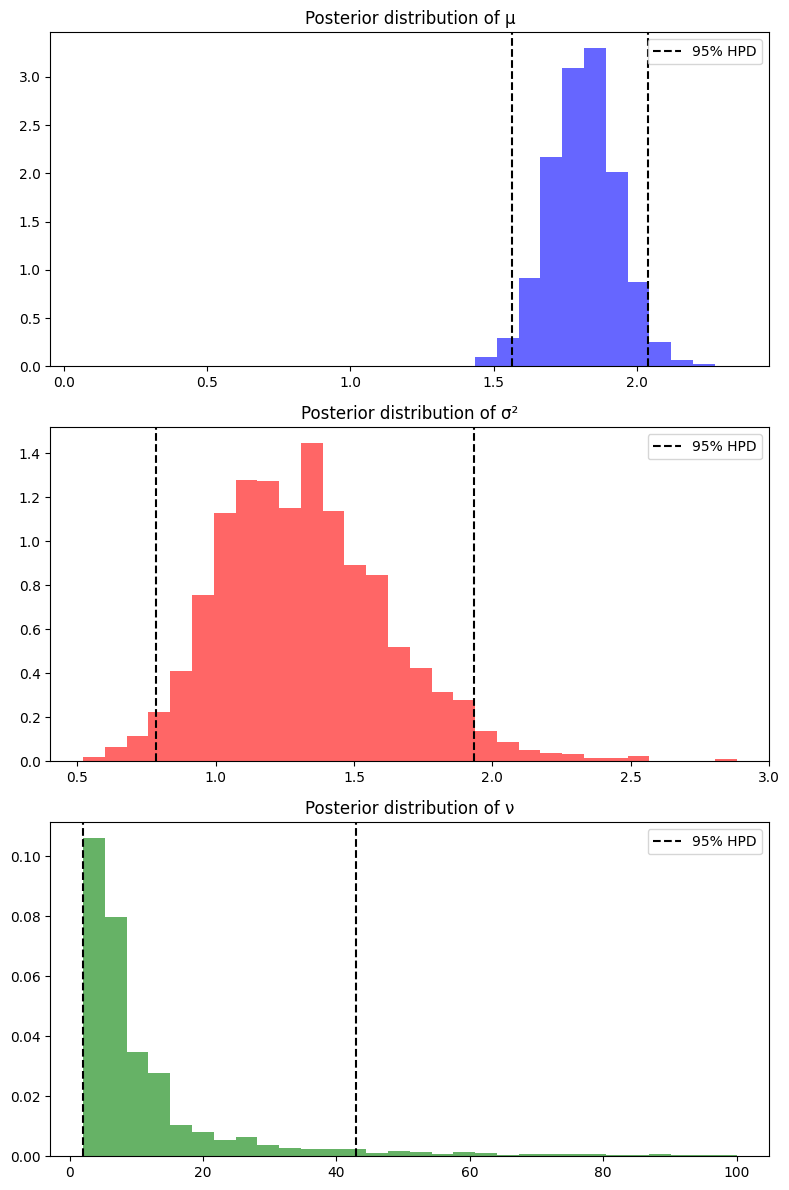

95% HPD interval for μ: (1.5631797813291053, 2.0385922706267916)
95% HPD interval for σ²: (0.7855754424604454, 1.9334336905320888)
95% HPD interval for ν: (2, 43)


In [3]:
# Q1
np.random.seed(365)

# Log Posterior Function
def log_posterior(mu, sigma2, nu, x):
    n = len(x)
    log_prior_mu = stats.norm.logpdf(mu, loc=0, scale=np.sqrt(1))  # Normal prior
    log_prior_sigma2 = np.log(2 / np.pi) - 0.5 * sigma2 ** 2  # Half-normal prior
    log_prior_nu = -np.log(100) if 1 <= nu <= 100 else -np.inf  # Discrete uniform

    log_likelihood = np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))

    return log_likelihood + log_prior_mu + log_prior_sigma2 + log_prior_nu

# Metropolis within Gibbs Sampler
def metropolis_within_gibbs(x, iterations=5000, mu_init=0, sigma2_init=1, nu_init=10):
    n = len(x)
    mu_samples = np.zeros(iterations)
    sigma2_samples = np.zeros(iterations)
    nu_samples = np.zeros(iterations, dtype=int)

    mu_current = mu_init
    sigma2_current = sigma2_init
    nu_current = nu_init

    for i in range(iterations):
        # Sample mu by MH
        mu_proposal = np.random.normal(mu_current, 0.5)
        log_alpha_mu = log_posterior(mu_proposal, sigma2_current, nu_current, x) - \
                       log_posterior(mu_current, sigma2_current, nu_current, x)
        if np.log(np.random.uniform()) < log_alpha_mu:
            mu_current = mu_proposal

        # Sample sigma2 by MH
        sigma2_proposal = np.abs(np.random.normal(sigma2_current, 0.5))  # Ensure positivity
        log_alpha_sigma2 = log_posterior(mu_current, sigma2_proposal, nu_current, x) - \
                           log_posterior(mu_current, sigma2_current, nu_current, x)
        if np.log(np.random.uniform()) < log_alpha_sigma2:
            sigma2_current = sigma2_proposal

        # Sample nu using Discrete Metropolis Step
        nu_proposal = np.random.randint(1, 101)
        log_alpha_nu = log_posterior(mu_current, sigma2_current, nu_proposal, x) - \
                       log_posterior(mu_current, sigma2_current, nu_current, x)
        if np.log(np.random.uniform()) < log_alpha_nu:
            nu_current = nu_proposal

        # Store Samples
        mu_samples[i] = mu_current
        sigma2_samples[i] = sigma2_current
        nu_samples[i] = nu_current

    return mu_samples, sigma2_samples, nu_samples

# Generate Data
np.random.seed(42)
n = 100
true_mu = 2
true_sigma2 = 1.5
true_nu = 10
x = stats.t.rvs(df=true_nu, loc=true_mu, scale=np.sqrt(true_sigma2), size=n)

# Gibbs Sampler
mu_samples, sigma2_samples, nu_samples = metropolis_within_gibbs(x, iterations=5000)

# Bayesian Inference
def hpd_interval(samples, alpha=0.05):
    sorted_samples = np.sort(samples)
    n = len(sorted_samples)
    interval_idx = int(np.floor(n * (1 - alpha)))
    intervals = [sorted_samples[i:i + interval_idx] for i in range(n - interval_idx)]
    hpd = min(intervals, key=lambda x: x[-1] - x[0])
    return hpd[0], hpd[-1]

mu_hpd = hpd_interval(mu_samples)
sigma2_hpd = hpd_interval(sigma2_samples)
nu_hpd = hpd_interval(nu_samples)

# Plots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].hist(mu_samples, bins=30, density=True, alpha=0.6, color='b')
axs[0].axvline(mu_hpd[0], color='k', linestyle='dashed', label="95% HPD")
axs[0].axvline(mu_hpd[1], color='k', linestyle='dashed')
axs[0].set_title("Posterior distribution of \u03BC")
axs[0].legend()

axs[1].hist(sigma2_samples, bins=30, density=True, alpha=0.6, color='r')
axs[1].axvline(sigma2_hpd[0], color='k', linestyle='dashed', label="95% HPD")
axs[1].axvline(sigma2_hpd[1], color='k', linestyle='dashed')
axs[1].set_title("Posterior distribution of \u03C3²")
axs[1].legend()

axs[2].hist(nu_samples, bins=30, density=True, alpha=0.6, color='g')
axs[2].axvline(nu_hpd[0], color='k', linestyle='dashed', label="95% HPD")
axs[2].axvline(nu_hpd[1], color='k', linestyle='dashed')
axs[2].set_title("Posterior distribution of \u03BD")
axs[2].legend()

plt.tight_layout()
plt.show()

# Print HPD Intervals
print(f"95% HPD interval for \u03BC: {mu_hpd}")
print(f"95% HPD interval for \u03C3²: {sigma2_hpd}")
print(f"95% HPD interval for \u03BD: {nu_hpd}")


### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

In [4]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

Output()

Output()

Output()

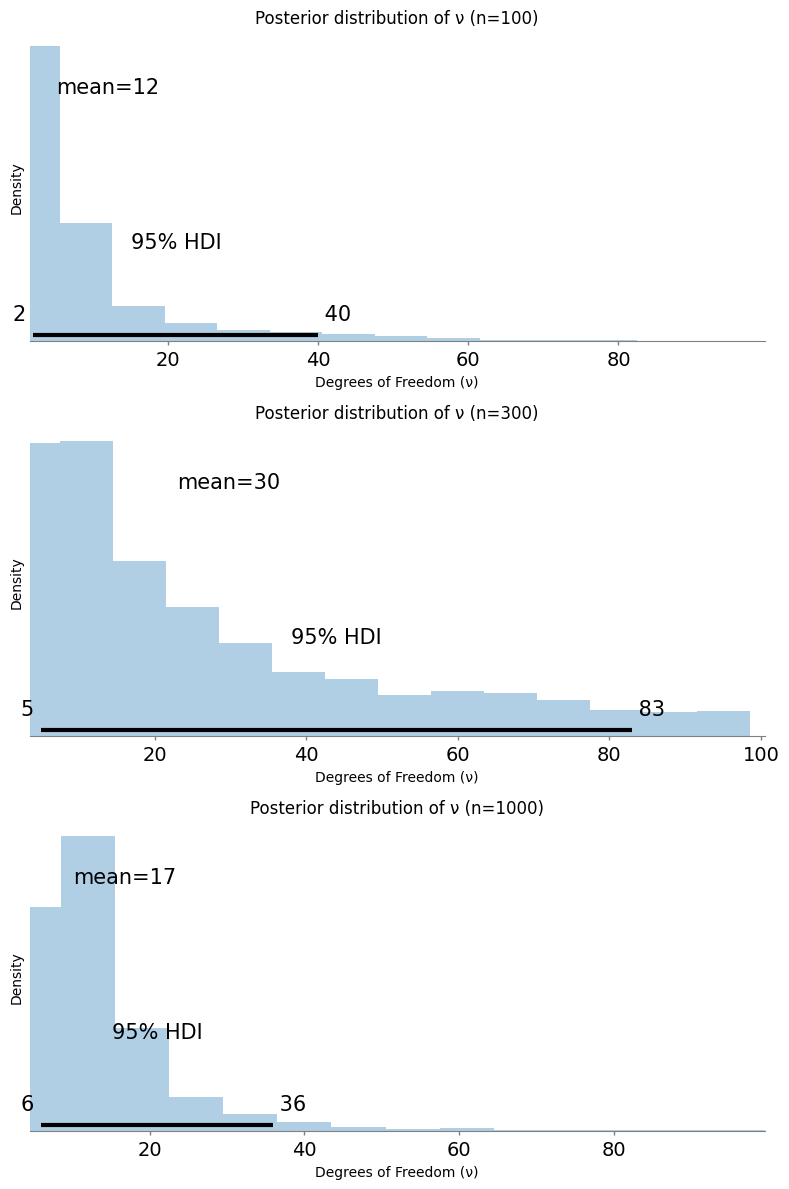


Summary for sample size 100:
  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
11.856 12.503     2.0     37.0      0.977    0.706     261.0     173.0   1.01

Summary for sample size 300:
  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
29.737 24.038     4.0     79.0       1.14    0.806     375.0     404.0    1.0

Summary for sample size 1000:
  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
16.825 11.043     6.0     33.0      0.812    0.639     363.0     268.0    1.0


In [11]:
# Q2
np.random.seed(365)

# Function to perform Bayesian inference on v for different sample sizes
def bayesian_inference_on_v(sample_size, true_mu=2, true_sigma2=1.5, true_nu=10, draws=3000):
    np.random.seed(42)
    x = np.random.standard_t(df=true_nu, size=sample_size) * np.sqrt(true_sigma2) + true_mu

    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)

        likelihood = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)

        trace = pm.sample(draws, tune=1000, return_inferencedata=True, cores=2)

    return trace

# Adjusted sample sizes to improve posterior visualization
sample_sizes = [100, 300, 1000]
inference_results = {}
for n in sample_sizes:
    inference_results[n] = bayesian_inference_on_v(n)

# Extract posterior samples correctly and improve visualization
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
for idx, n in enumerate(sample_sizes):
    az.plot_posterior(inference_results[n].posterior["nu"], ax=axes[idx], hdi_prob=0.95)
    axes[idx].set_title(f"Posterior distribution of \u03BD (n={n})")
    axes[idx].set_xlabel("Degrees of Freedom (\u03BD)")
    axes[idx].set_ylabel("Density")
plt.tight_layout()
plt.show()

# Summarize results and format output
for n in sample_sizes:
    summary = az.summary(inference_results[n], var_names=["nu"], hdi_prob=0.94)

    # Rename columns to match the desired format
    summary = summary.rename(columns={
        "hdi_2.5%": "hdi_3%",
        "hdi_97.5%": "hdi_97%"
    })

    # Select only relevant columns
    summary = summary[["mean", "sd", "hdi_3%", "hdi_97%", "mcse_mean", "mcse_sd", "ess_bulk", "ess_tail", "r_hat"]]

    print(f"\nSummary for sample size {n}:")
    print(summary.to_string(index=False))  # Remove row index for cleaner output




Explanation... :)

### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



### Q3 Answer

This integral simplifies to a Student's t-Distribution when integrating out the uncertainty in $\tau_i$. The posterior predictive distribution of a normal model with an unknown variance thus follows a Student's t-Distribution where the heavy tails of the t-distribution account for additional uncertainty in the estimation of the variance.

The behavior demonstrated here matches the behavior of Bayesian posterior predictive inference because when new observations are predicted in Bayesian inference, we integrate over the uncertainty in parameters (exactly the same as how $\tau_i$ was integrated over in this context).

References: used OpenAI to generate sections of code.